In [1]:
!pip install catboost;

You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from catboost import CatBoostClassifier

%matplotlib inline

This is programming assignment for week 5. In this assignment you will be solving classification task. 

### Grading
The assignment contains both automatically graded and peer reviewed tasks. 

**Automatic grading**\
After you finish solving all the tasks restart the kernel (`kernel -> restart`) and and click button `Validate` to check that everything works as expected. Afterwards, you can submit your work.


**Competition**\
In the second part of the assignment you are asked to train the model with the best score on test dataset. Note, that you are not given correct answers on the test dataset. To get your score, use Kaggle competition, that we've created for you. **The score on the Kaggle liderboard will not affect your grade, instead you need to submit your best result to the separate programming assignment `Predictions on the test set.`** This task is considered passed if your $F_1$ score on the test is larger than 0.7. But we encourage you to try and get larger scores, you can definitely do it:)


**Peer Review**\
Some of the tasks cannot be checked automatically,  therefore, we'll be using peer review. Please, download this notebook with solutions (`File → Download as → Notebook (.ipynb)`) and submit it for peer review. Each peer reviewed task contains grading instructions. 



# Table of Contents:
* [Part1.](#part1) Decision Trees
 - [Task 1](#task1)[1 pt]
 - [Task 2](#task2)[1 pt]
 - [Task 3](#task3)[Peer Review]
* [Part2.](#part2) Competition! [Peer Review]
    

## Part 1. Let's train some decision trees. <a class="anchor" id="part1"></a>

In this part, we will do the simplest preprocessig of the dataset and train decision trees. In the task, you are supposed to predict whether income of a person exceeds \$50K/year. The target variable is equal to `1` if a person earns > \$50k/year and `0` otherwise. 

As an evaluation criterion, we will be using $F_1$score. As you know, it is a weighted average of precision and recall. We are not using accuracy, because the dataset is imbalanced. 

In [3]:
train_data = pd.read_csv('week5_train.csv')
train_data.head()

,age,workclass,education,education_years,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0.0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0.0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0.0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0.0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0.0


In [4]:
from sklearn.model_selection import train_test_split

tr, val = train_test_split(train_data, test_size=0.4, random_state=42)

y_train = tr.target
y_valid = val.target
X_train = tr.drop(['target'], axis=1)
X_valid = val.drop(['target'], axis=1)

<a class="anchor" id="task1"></a>

---
**Task 1** [1 pt] Create `column_transformer` which has the following steps:
- fills all the missing values 
- encodes all the categorical features using OHE 
- scales numerical features.

P.S. note, that you'll have to import all the required modules yourself.

In [5]:
# your code here
num_cols = X_train.select_dtypes('number').columns
cat_cols = X_train.select_dtypes('object').columns

num_pipe = make_pipeline(
    SimpleImputer(),
    StandardScaler()
)

cat_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

column_transformer = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
], remainder='passthrough')



In [6]:
X_transformed = column_transformer.fit_transform(X_train)
X_transformed.shape

X_transformed = column_transformer.fit_transform(X_train)
assert X_transformed.shape[0] == 19536
assert X_transformed.shape[1] == 104

<a class="anchor" id="task2"></a>

---
**Task 2** [1 pt] Create a function `tree_pipe`, which given a maximal tree depth returns a pipeline with two steps:

1. Column transformer (defined above)
2. DecisionTreeClassfier with the required `max_depth` parameter

In [7]:
def tree_pipe(max_depth):
    # your code here
    pipeline = make_pipeline(
        column_transformer,
        DecisionTreeClassifier(max_depth=max_depth)
    )
    
    return pipeline

In [8]:
test_pipe = tree_pipe(1)

test_pipe = tree_pipe(12)
tree = test_pipe.steps[1][1]
assert tree.max_depth == 12

<a class="anchor" id="task3"></a>

---
**Task 3** [Peer Reviewed] Fit decision trees of different depth (from 1 to 100) using the function from the **task 2**. For each depth calculate $F_1$score on the train and validation datasets. Draw a plot, how both scores depend on the maximal tree depth

In [9]:
from sklearn.metrics import f1_score

# your code here
tr_score, te_score = [], []
for i in range(1, 200, 5):
    
    tpipe = tree_pipe(i)
    tpipe.fit(X_train, y_train)
    
    y_pred = tpipe.predict(X_train)
    tr_score.append(f1_score(y_train, y_pred))
    
    y_pred = tpipe.predict(X_valid)
    te_score.append(f1_score(y_valid, y_pred))

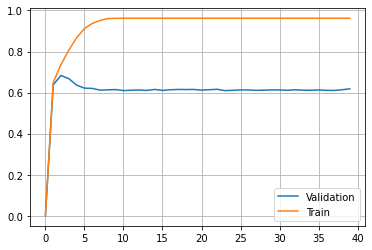

In [10]:
plt.plot(te_score, label='Validation')
plt.plot(tr_score, label='Train')

plt.grid()
plt.legend()

In [11]:
pass

**Peer Review Grading.** Please check that the plot above is correct (below you can see the correct answer).

<img src="Correct_f1.png" width=400 height=400 />


---

## Part 2. Let's compete. <a class="anchor" id="part2"></a>

In this second part of the assignment your task will be straightforward: achieve the best possible score on the test set. To make everything fair, we will be using [Kaggle competition](https://www.kaggle.com/c/predict-income-group). 

At this stage you are free to use any models or preprocessing methods you want. You can use assignments from the previous weeks as an inspiration!

Below you can see how the test dataset can be loaded.  

In [12]:
test_data = pd.read_csv('week5_test.csv')
test_data.head()

,age,workclass,education,education_years,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,NaN,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States


Even though we do not restrict you a lot in this task, we still ask you to stick to the following steps, which will be graded by your peers

**Peer Review Grading.** Below you will find the list of criteria for peer review:
1. Consider categorical features. Show which feature are categorical, check if all the categories are reasonable. Provide plots.
2. Consider numerical features
3. Fill missing values. 
4. Explore different hyperparameters of the decision trees (not only `max_depth`)
5. Choose the best model using cross-validation or just validation
6. Make a prediction on the test set.
7. Try to make your code readable. Do not forget to leave comments.

In [13]:
# Split again the information, leaving a smaller set for testing
tr, val = train_test_split(train_data, test_size=0.2, random_state=42)

y_train = tr.target
y_valid = val.target
X_train = tr.drop(['target'], axis=1)
X_valid = val.drop(['target'], axis=1)

In [14]:
# 1 Check Categorical features

In [15]:
cat_cols

Index(['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country'],
      dtype='object')

In [16]:
X_train[cat_cols].head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country
5514,Local-gov,Bachelors,Never-married,Prof-specialty,Not-in-family,White,Female,United-States
19777,Private,Assoc-voc,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
10781,Self-emp-not-inc,9th,Separated,Craft-repair,Not-in-family,White,Male,United-States
32240,Private,Assoc-voc,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States
9876,Private,Some-college,Divorced,Other-service,Not-in-family,White,Male,United-States


In [17]:
X_train[cat_cols].describe()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country
count,24601,26048,26048,24594,26048,26048,26048,25590
unique,8,16,7,14,6,5,2,41
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,18118,8416,12026,3312,10603,22221,17403,23300


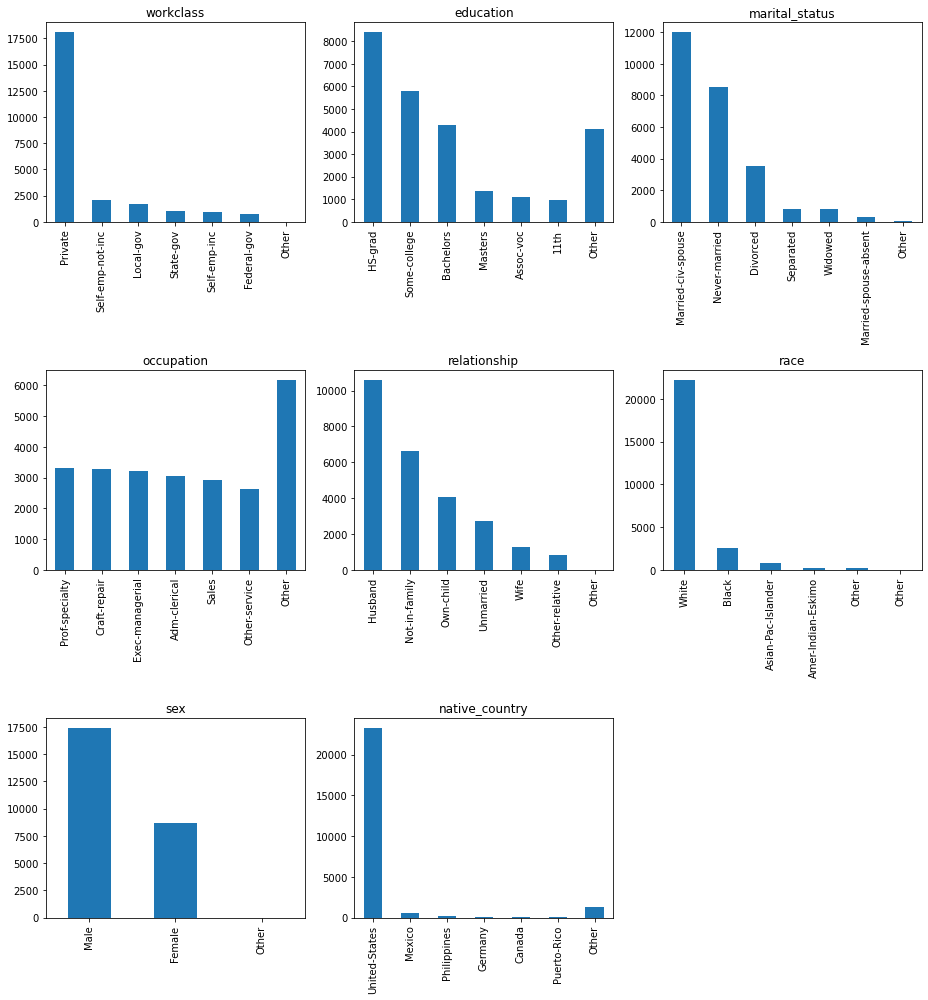

In [18]:
n = 6
figure = plt.figure(figsize=(13,14))

for i, cat in enumerate(cat_cols):
    grouped_vals = X_train.groupby(cat)['age'].count().sort_values(ascending=False)
    other = grouped_vals[n:].values.sum()
    #for val in grouped_vals[:n]:
    #    X_train.loc[X_train[cat] == val, cat] = 'Other'
    #    X_valid.loc[X_valid[cat] == val, cat] = 'Other'
    
    
    grouped_vals = grouped_vals[:n].append(pd.Series(data=[other], index=['Other']))

    ax = plt.subplot(3, 3, i + 1)
    grouped_vals.plot.bar()
    plt.title(cat)
    
figure.tight_layout()

In [19]:
# 2 Numerical Features

In [20]:
num_cols

Index(['age', 'education_years', 'capital_gain', 'capital_loss',
       'hours_per_week'],
      dtype='object')

In [21]:
X_train[num_cols].head()

,age,education_years,capital_gain,capital_loss,hours_per_week
5514,33,13,0,0,50
19777,36,11,0,1887,50
10781,58,5,0,0,40
32240,21,11,0,0,46
9876,27,10,0,0,40


In [22]:
X_train[num_cols].describe()

,age,education_years,capital_gain,capital_loss,hours_per_week
count,26048.000000,26048.000000,26048.000000,26048.000000,26048.000000
mean,38.576513,10.080544,1053.617437,87.988828,40.388552
std,13.642904,2.575202,7230.800656,403.629787,12.331139
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


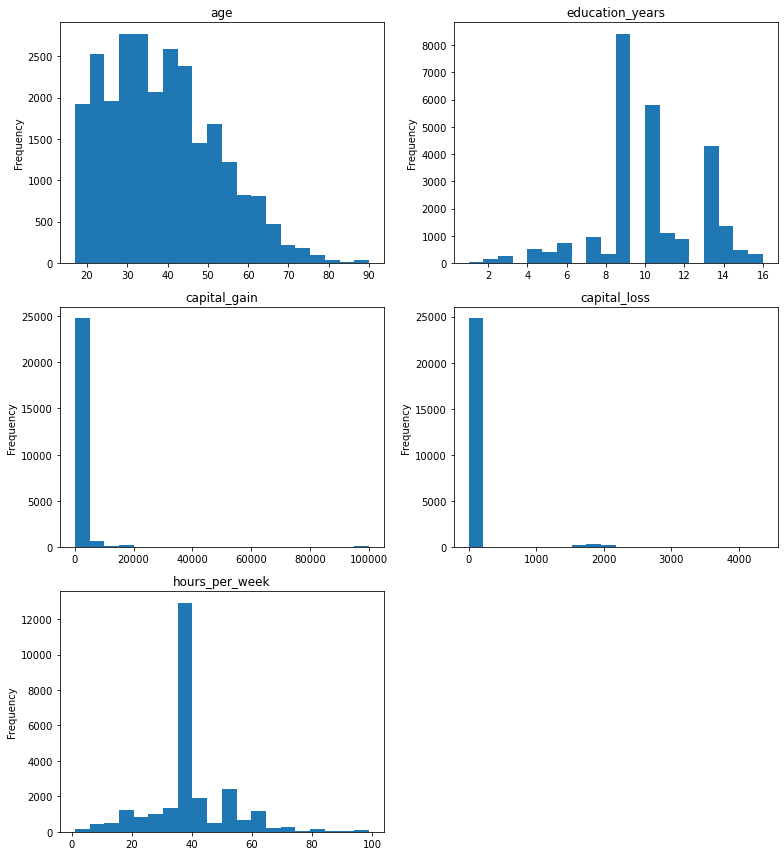

In [23]:
figure = plt.figure(figsize=(11,12))

for i, num in enumerate(num_cols):
    ax = plt.subplot(3, 2, i + 1)
    X_train[num].plot.hist(bins=20)
    plt.title(num)
    
figure.tight_layout()

In [24]:
# 3 Impute Values, 4 Explore different values, 5 Choose the best model using cross-validation or just validation

In [25]:
# Try first with the model we already had, the Decision Tree

num_cols = X_train.select_dtypes('number').columns
cat_cols = X_train.select_dtypes('object').columns

num_pipe = make_pipeline(
    SimpleImputer(),
    StandardScaler()
)

cat_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

column_transformer = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
], remainder='passthrough')

tree_pipe = Pipeline([
    ('trans', column_transformer),
    ('dtree', DecisionTreeClassifier())
])

In [26]:
param_grid = [
    {
        'dtree__max_depth': [1, 5, 10, 20, 50],
        'dtree__criterion': ['gini', 'entropy'],
        'dtree__splitter': ['best', 'random'],
        'dtree__max_features': ['auto', 'sqrt', 'log2']
    }
]

grid_pipe = GridSearchCV(tree_pipe, param_grid, scoring='accuracy')
grid_pipe.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('trans',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                           

In [27]:
grid_pipe.best_estimator_.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('trans',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                         

In [28]:
y_pred = grid_pipe.best_estimator_.predict_proba(X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, 1])
f1_scores = 2*recall*precision/(recall+precision)
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

Best threshold:  0.3815879534565366
Best F1-Score:  0.6530062011323807


### CatBoost

In [29]:
# Let's try with a way better algo: CatBoost

In [30]:
y_train.mean()

0.24070945945945946

In [31]:
X_train_trans = column_transformer.fit_transform(X_train)
X_valid_trans = column_transformer.transform(X_valid)

# I am using class weights since dataset is unbalanced (there are more 0s than 1s)
cboost = CatBoostClassifier(iterations=420, class_weights=[1, 76./24])

cboost.fit(X_train_trans, y_train,
          eval_set=(X_valid_trans, y_valid))

Learning rate set to 0.103393
0:	learn: 0.6271477	test: 0.6270739	best: 0.6270739 (0)	total: 583ms	remaining: 4m 4s
1:	learn: 0.5702923	test: 0.5710456	best: 0.5710456 (1)	total: 1.09s	remaining: 3m 47s
2:	learn: 0.5300222	test: 0.5303116	best: 0.5303116 (2)	total: 1.48s	remaining: 3m 26s
3:	learn: 0.5020362	test: 0.5024555	best: 0.5024555 (3)	total: 2.08s	remaining: 3m 36s
4:	learn: 0.4764115	test: 0.4775845	best: 0.4775845 (4)	total: 2.6s	remaining: 3m 35s
5:	learn: 0.4609754	test: 0.4626309	best: 0.4626309 (5)	total: 3.09s	remaining: 3m 33s
6:	learn: 0.4442677	test: 0.4453051	best: 0.4453051 (6)	total: 3.69s	remaining: 3m 37s
7:	learn: 0.4337306	test: 0.4350170	best: 0.4350170 (7)	total: 4.28s	remaining: 3m 40s
8:	learn: 0.4243536	test: 0.4256318	best: 0.4256318 (8)	total: 4.69s	remaining: 3m 34s
9:	learn: 0.4168028	test: 0.4183455	best: 0.4183455 (9)	total: 5.29s	remaining: 3m 36s
10:	learn: 0.4111507	test: 0.4127236	best: 0.4127236 (10)	total: 5.79s	remaining: 3m 35s
11:	learn: 0.

In [32]:
y_pred = cboost.predict_proba(X_valid_trans)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, 1])
f1_scores = 2*recall*precision/(recall+precision)
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

Best threshold:  0.6926273140257709
Best F1-Score:  0.7398321497740478


In [33]:
# Sweet, increase of best f1 score from 0.63 to 0.74

In [34]:
# Now train with the whole data set to make submission
X = train_data.drop(['target'], axis=1)
y = train_data['target']

In [35]:
X_trans = column_transformer.fit_transform(X)
X_test_trans = column_transformer.transform(test_data)

cboost = CatBoostClassifier(iterations=420, class_weights=[1, 76./24])
cboost.fit(X_trans, y)

Learning rate set to 0.101003
0:	learn: 0.6222800	total: 445ms	remaining: 3m 6s
1:	learn: 0.5711406	total: 1.04s	remaining: 3m 37s
2:	learn: 0.5303403	total: 1.64s	remaining: 3m 48s
3:	learn: 0.5002120	total: 2.15s	remaining: 3m 43s
4:	learn: 0.4767696	total: 2.74s	remaining: 3m 47s
5:	learn: 0.4581546	total: 3.24s	remaining: 3m 43s
6:	learn: 0.4420112	total: 3.84s	remaining: 3m 46s
7:	learn: 0.4312640	total: 4.34s	remaining: 3m 43s
8:	learn: 0.4227039	total: 4.85s	remaining: 3m 41s
9:	learn: 0.4161065	total: 5.34s	remaining: 3m 38s
10:	learn: 0.4096163	total: 5.75s	remaining: 3m 33s
11:	learn: 0.4044665	total: 6.15s	remaining: 3m 29s
12:	learn: 0.4004166	total: 6.64s	remaining: 3m 27s
13:	learn: 0.3975086	total: 7.04s	remaining: 3m 24s
14:	learn: 0.3948690	total: 7.54s	remaining: 3m 23s
15:	learn: 0.3919591	total: 8.04s	remaining: 3m 22s
16:	learn: 0.3887183	total: 8.54s	remaining: 3m 22s
17:	learn: 0.3858100	total: 8.94s	remaining: 3m 19s
18:	learn: 0.3830265	total: 9.14s	remaining: 

In [37]:
# We are predicting proba and not classes since we want to use the best threshold for f1-score we found previously
catboost_pred = cboost.predict_proba(X_test_trans)

In [38]:
# Choose the threshold that maximizes f1-score

catboost_pred = 1 * (catboost_pred[:, 1] >= thresholds[np.argmax(f1_scores)])

In [39]:
output = pd.DataFrame(catboost_pred, columns=['Prediction'])

In [40]:
output['Prediction'] = output['Prediction'].astype('int')

In [41]:
output.to_csv('submission_1_cboost.csv',index_label='Id')

In [42]:
# Do not forget to save your predictions on test and submit them on Kaggle

Below you can see, how `csv` file with the prediction can be created and saved. This file can be later used to upload to Kaggle. Please note, that type of the prediction should be `integer`. 

In [43]:
sample_prediction = np.ones(test_data.shape[0], dtype=int)

In [44]:
sample_prediction = np.ones(test_data.shape[0], dtype=int)
pd.DataFrame({'Prediction': sample_prediction}).to_csv('my_prediction.csv')

Do not forget to submit your best prediction to the `Predictions on the test set.` programming assignment!

This file will be saved to 

1. Click the Jupyter logo on the top left corner, which will take you to the file tree view.
2. Go to the `release/week5` folder, the file `'my_prediction.csv'` should already be there. If not, make sure that you've ran the cell above.
3. When you select this file using a tick box, the bottomn `Download` will appear on the top panel. Use it to download the file.